In [2]:
# R.version.string
# install.packages("remotes")
# remotes::install_github("plotly/dashR", upgrade = "always")
library(dash)
library(tidyverse)
library(ggplot2)


-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.1     v purrr   1.0.1
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 0.5.2
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [3]:
hits <- read.csv('../data/processed/audio_data_processed.csv')
hits <- hits[,!(names(hits) %in% c("Unnamed..0",'type','uri','track_href','analysis_url','id'))]

hits$rank_bin <-cut(hits$Rank, breaks = 10,labels=c('1-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'))
titleParams <- list(c( "Vibe Features Over Rank",  "Energy, speechiness, instrumentalness,valence in different strata of the charts"),
c( "Rhythm Features Over Year",  "Time signature, tempo, duration occurences"),
c( "Musical Features Interaction",  "Musical key, mode occurences"))
start_year <- 2012; end_year<-2022
hits_c <- hits[(start_year <= hits$Year) & (hits$Year <= end_year),]
str(hits_c)
titleParams[[1]][1]


'data.frame':	1100 obs. of  20 variables:
 $ Year            : int  2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 ...
 $ Rank            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Title           : chr  "Somebody That I Used to Know" "Call Me Maybe" "We Are Young" "Payphone" ...
 $ Artist          : chr  "Gotye feat Kimbra" "Carly Rae Jepsen" "Fun feat Janelle Mon\303\241e" "Maroon 5 feat Wiz Khalifa" ...
 $ track_id        : chr  "0RtMRbaqeadQFvlYxcAczv" "3TGRqZ0a2l1LRblBkJoaDx" "7a86XRg84qjasly9f6bPSD" "1UhGntCpnptxUsNjFrweVe" ...
 $ popularity      : int  34 70 70 1 62 75 63 42 71 81 ...
 $ danceability    : num  0.646 0.783 0.378 0.782 0.703 0.722 0.562 0.769 0.747 0.726 ...
 $ energy          : num  0.642 0.58 0.638 0.674 0.731 0.851 0.939 0.787 0.716 0.787 ...
 $ key             : int  0 7 10 11 8 7 0 1 11 4 ...
 $ loudness        : num  -6.19 -6.55 -5.58 -9.12 -6.28 ...
 $ mode            : int  1 1 1 1 0 0 1 1 0 1 ...
 $ speechiness     : num  0.0412 0.0408 0.075 0.0388 0.0311 0.06

[1] "Vibe Features Over Rank"

In [62]:
options(repr.plot.width=15, repr.plot.height=6)
hits$Year <- factor(hits$Year)
hits$key <- factor(hits$key)
hits$mode <- factor(hits$mode)

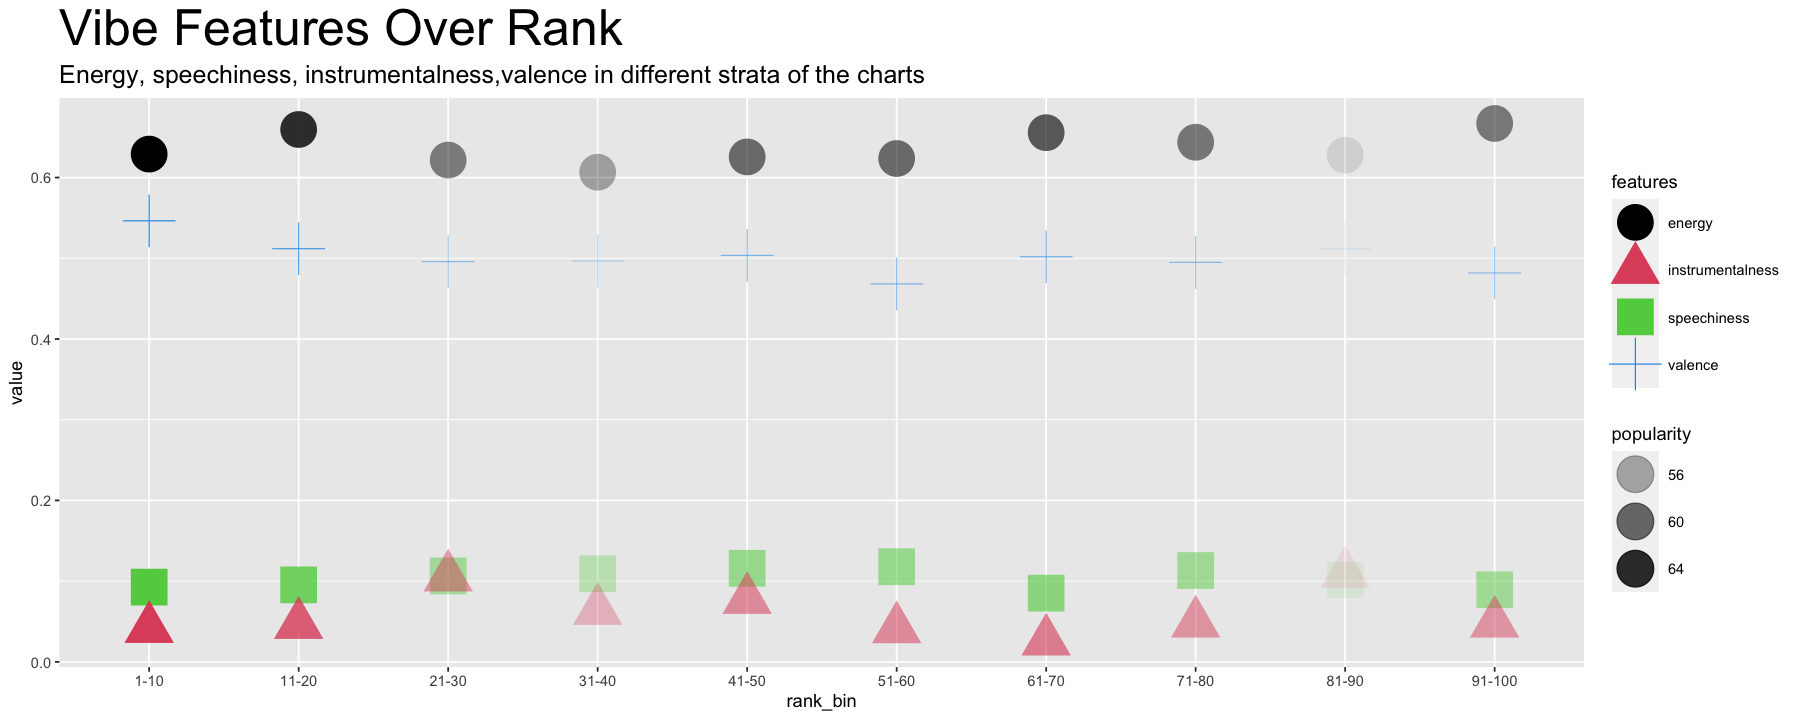

In [11]:
# Chart
options(repr.plot.width=15, repr.plot.height=6)
hits_c_bin <- hits_c %>% group_by(rank_bin) %>%   
summarise(popularity=mean(popularity),energy=mean(energy),speechiness=mean(speechiness),instrumentalness=mean(instrumentalness),valence=mean(valence)) %>% 
select(c('rank_bin','popularity','energy','speechiness','instrumentalness','valence'))

# # # stack those features
# # hits_c_bin_st <- hits_c_bin[,!(names(hits_c_bin) %in% c('energy','speechiness','instrumentalness','valence'))] %>% 
# # cbind(stack(hits_c_bin[c('energy','speechiness','instrumentalness','valence')])) %>%
# # rename(value=values, features=ind)
hits_c_bin_st <- hits_c_bin %>%  gather(features, value, -c(rank_bin,popularity)) # another way to stack


hits_c_bin_st %>%
  ggplot(aes(x=rank_bin,y=value)) + geom_point(aes(color = features,shape=features,alpha=popularity),size=10) +
    scale_colour_manual(values=c("1", "2", "3", "4"))+
    labs(title=titleParams[[1]][1], subtitle = titleParams[[1]][2])+
    theme(plot.title = element_text(size=30),plot.subtitle=element_text(size=15))

chart_describ <- 
"
 - The **energy** represents the intensity and activity; 
 - The **speechness** detects the degree of presence spoken words; 
 - The **instrumentalness** predicts whether a track contains no vocals; 
 - The **valence** describing the musical positiveness.
 "


TableGrob (1 x 3) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]

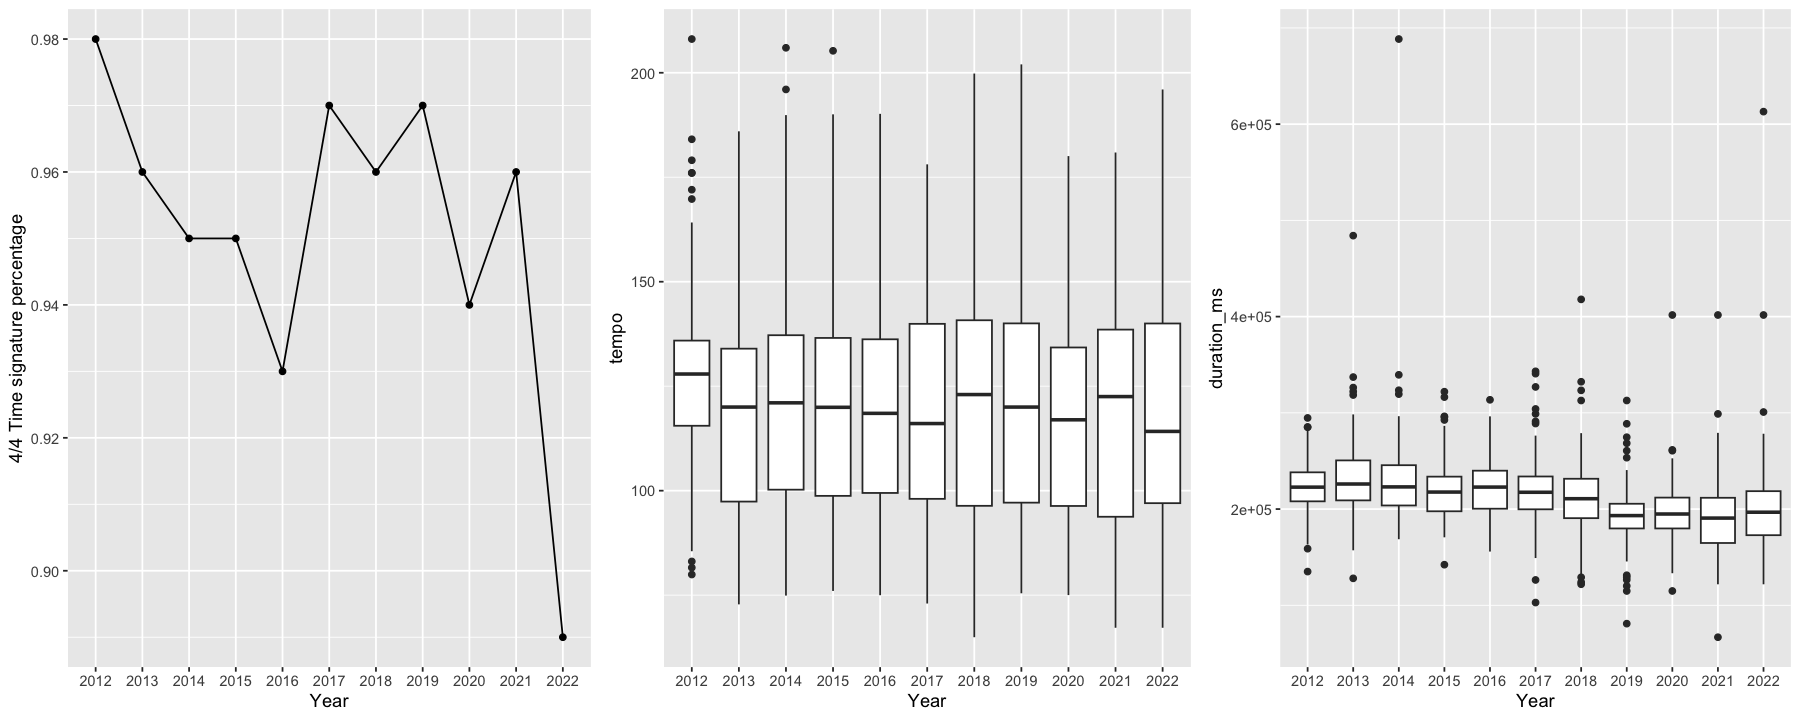

In [55]:
# Chart1
require(gridExtra)

hits_c1 <- hits %>% group_by(Year,time_signature) %>% count() %>% rename(cnt=n) 
hits_c1$ts_perct <- hits_c1$cnt/100

chart1_1 <- ggplot(hits_c1[hits_c1['time_signature']==4,],aes(x=Year,y=ts_perct,group = 1))+
geom_line()+
geom_point()+
labs(x='Year',y='4/4 Time signature percentage')

chart1_2 <- ggplot(hits[,c('Year','duration_ms','tempo')],aes(x=Year,y=tempo,group = Year))+
geom_boxplot()

chart1_3 <- ggplot(hits[,c('Year','duration_ms','tempo')],aes(x=Year,y=duration_ms,group = Year))+
geom_boxplot()

chart1 <- grid.arrange(chart1_1, chart1_2, chart1_3, ncol=3)

chart1
chart1_describ <- 
"
- The **time signiture** (aka. meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of \"3/4\", to \"7/4\"; 
- The **tempo** (aka. beats per minute, BPM), which is the speed or pace of a given piece and derives directly from the average beat duration; 
- The **duration** is the duration of the track in milliseconds.
"

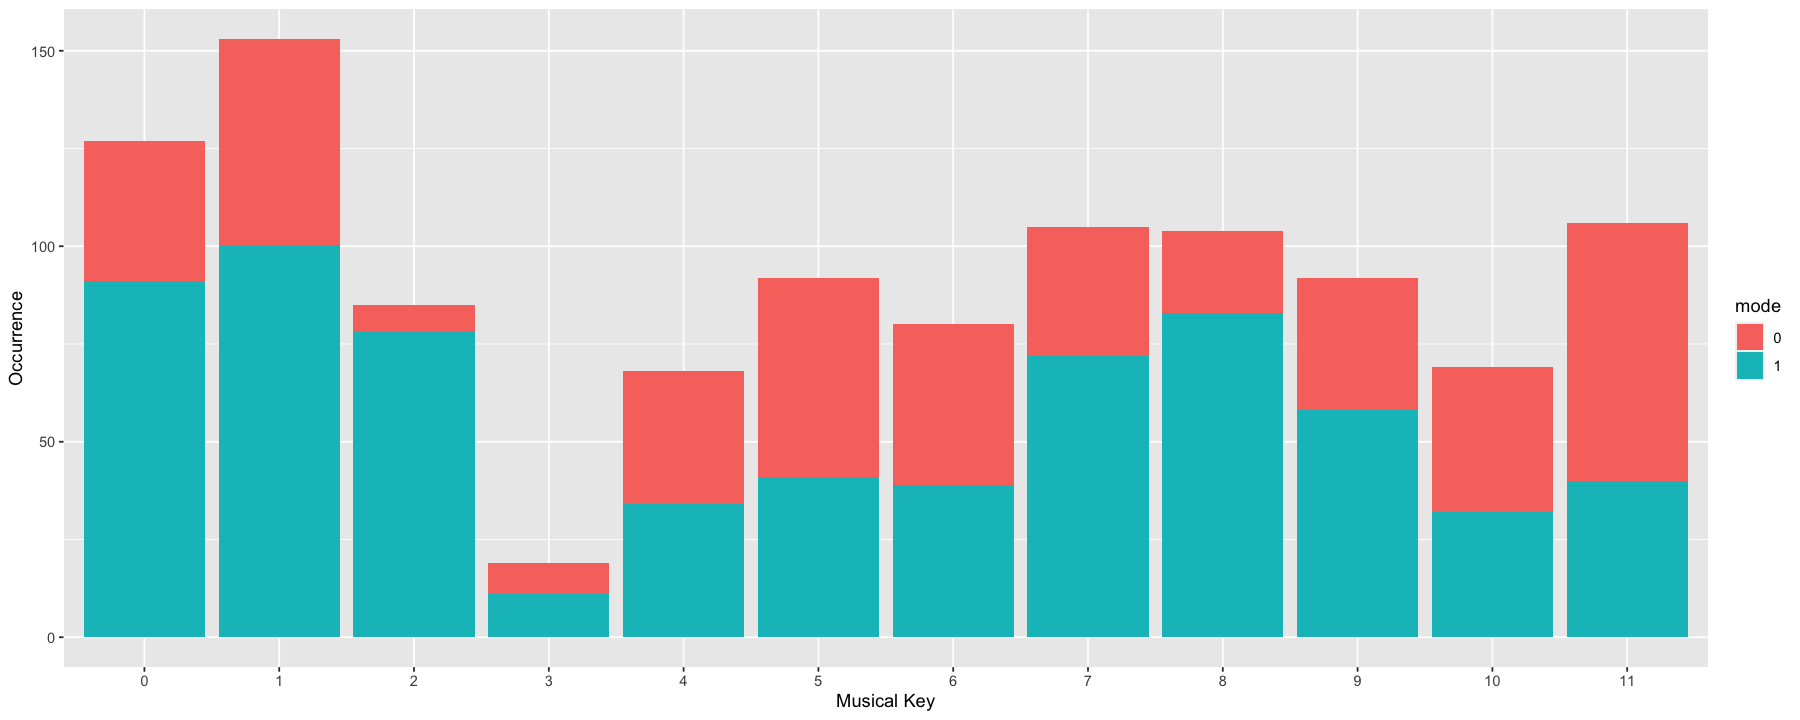

In [72]:
#chart2
chart2 = ggplot(hits) + 
geom_bar(aes(x=key,fill = mode),stat = "count") + 
labs(x='Musical Key',y='Occurrence')
chart2
chart2_describ = "
- The **musical** key represents the scale, where values are integers that can map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on; 
- The **mode** indicates the modality (major or minor), which is the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
"